In [1]:
import matplotlib.pyplot as plt
import functools
import skbio
import scipy as sp
from scipy import cluster
from typing import Callable
import collections

import numpy as np
import sys
from skbio.io import read
from skbio import DNA, TabularMSA

In [2]:
# regenerate the keys
import os
os.system('python3 gen.py')

0

In [3]:
input_file_path = 'fam_unknown.fasta'
output_file_path = 'regen.fasta'

In [4]:
#copied from skbio cookbook
query_sequences = []
sequences = collections.OrderedDict()
for seq in skbio.io.read(input_file_path, format='fasta'):
    seq_id = seq.metadata['description']
    #seq_tax = ' '.join(taxonomies[seq.metadata['id']].split('; ')[:display_tax_levels])
    #seq_id = '%s (%s)' % (seq.metadata['id'], seq_tax) 
    sequences[seq_id] = DNA(sequence=seq, metadata={'id': seq_id})
    query_sequences.append(DNA(sequence=seq, metadata={'id': seq_id}))

print(query_sequences)

[DNA
---------------------------------------------------------------------
Metadata:
    'id': 'Sequence_0'
Stats:
    length: 950
    has gaps: False
    has degenerates: False
    has definites: True
    GC-content: 49.79%
---------------------------------------------------------------------
0   GCCCCCACTC ATGCTCTATA ACTAGACGCC AACGCGTTCG CCGACATGGT TGCCTCATTC
60  CTACCGCGGG CCGAACCAAT AATGGGGGTT AAGCGTCCCC TAAGGCCACT CATGAATGAA
...
840 AAACGGGACG CGTGTCTCTA CAGGAAGCCA CATGGTTGCG GTAACATGAA GGAGAATGCC
900 AACTCAAGCC ACCCCCGATT CAAGTCCTCA ATTTGAGACT GTGGATCGAC, DNA
---------------------------------------------------------------------
Metadata:
    'id': 'Sequence_1'
Stats:
    length: 949
    has gaps: False
    has degenerates: False
    has definites: True
    GC-content: 48.89%
---------------------------------------------------------------------
0   GCCCCCACTC ATGCGCCAGT TTCAGGAGAC GCCAACGCGA GATAAGAAAT GGTTGCCTCC
60  CTATAGTTTG GACCGAACCA ATAATATTGT AAGCGTCCCC TAAGGCCTAA GAGGAATG

In [5]:
def kmer_distance(sequence1, sequence2, k=3, overlap=True):
    """Compute the kmer distance between a pair of sequences

    Parameters
    ----------
    sequence1 : skbio.Sequence
    sequence2 : skbio.Sequence
    k : int, optional
        The word length.
    overlapping : bool, optional
        Defines whether the k-words should be overlapping or not
        overlapping.

    Returns
    -------
    float
        Fraction of the set of k-mers from both sequence1 and
        sequence2 that are unique to either sequence1 or
        sequence2.

    Raises
    ------
    ValueError
        If k < 1.

    Notes
    -----
    k-mer counts are not incorporated in this distance metric.

    """
    sequence1_kmers = set(map(str, sequence1.iter_kmers(k=k, overlap=overlap)))
    sequence2_kmers = set(map(str, sequence2.iter_kmers(k=k, overlap=overlap)))
    all_kmers = sequence1_kmers | sequence2_kmers
    shared_kmers = sequence1_kmers & sequence2_kmers
    number_unique = len(all_kmers) - len(shared_kmers)
    fraction_unique = number_unique / len(all_kmers)
    return fraction_unique

In [30]:
from typing import Callable, Optional, TYPE_CHECKING

if TYPE_CHECKING:
    import skbio.SequenceCollection

# The recursive function:
def progressive_msa(sequences: "skbio.SequenceCollection", pairwise_aligner: Callable, guide_tree: skbio.TreeNode=None, metric: Optional[Callable]=kmer_distance) -> skbio.TabularMSA:
    """Perform progressive msa of sequences

    Parameters
    ----------
    sequences : skbio.SequenceCollection
        The sequences to be aligned.
    metric : function, optional
      Function that returns a single distance value when given a pair of
      skbio.Sequence objects. This will be used to build a guide tree if one
      is not provided.
    guide_tree : skbio.TreeNode, optional
        The tree that should be used to guide the alignment process.
    pairwise_aligner : function
        Function that should be used to perform the pairwise alignments,
        for example skbio.alignment.global_pairwise_align_nucleotide. Must
        support skbio.Sequence objects or skbio.TabularMSA objects
        as input.

    Returns
    -------
    skbio.TabularMSA

    """

    if guide_tree is None:
        guide_dm = skbio.DistanceMatrix.from_iterable(
            iterable=sequences, metric=metric, key="id"
        )
        guide_lm = sp.cluster.hierarchy.average(y=guide_dm.condensed_form())
        guide_tree = skbio.TreeNode.from_linkage_matrix(
            linkage_matrix=guide_lm, id_list=guide_dm.ids
        )

    seq_lookup = {s.metadata["id"]: s for i, s in enumerate(sequences)}

    # working our way down, first children may be super-nodes,
    # then eventually, they'll be leaves
    c1, c2 = guide_tree.children

    # Recursive base case
    if c1.is_tip():
        c1_aln = seq_lookup[c1.name]
    else:
        c1_aln = progressive_msa(
            sequences=sequences, pairwise_aligner=pairwise_aligner, guide_tree=c1
        )

    if c2.is_tip():
        c2_aln = seq_lookup[c2.name]
    else:
        c2_aln = progressive_msa(
            sequences=sequences, pairwise_aligner=pairwise_aligner, guide_tree=c2
        )

    # working our way up, doing alignments, from the bottom up
    alignment, _, _ = pairwise_aligner(seq1=c1_aln, seq2=c2_aln)

    # this is a temporary hack as the aligners in skbio 0.4.1 are dropping
    # metadata - this makes sure that the right metadata is associated with
    # the sequence after alignment
    if isinstance(c1_aln, skbio.Sequence):
        alignment[0].metadata = c1_aln.metadata
        len_c1_aln = 1
    else:
        for i in range(len(c1_aln)):
            alignment[i].metadata = c1_aln[i].metadata
        len_c1_aln = len(c1_aln)
    if isinstance(c2_aln, skbio.Sequence):
        alignment[1].metadata = c2_aln.metadata
    else:
        for i in range(len(c2_aln)):
            alignment[len_c1_aln + i].metadata = c2_aln[i].metadata

    # feed alignment back up, for further aligment, or eventually final return
    return alignment

In [36]:
# The recursive function:
def progressive_msa(sequences: "skbio.SequenceCollection", pairwise_aligner: Callable, guide_tree: skbio.TreeNode=None, metric: Optional[Callable]=kmer_distance) -> skbio.TabularMSA:
    """Perform progressive msa of sequences

    Parameters
    ----------
    sequences : skbio.SequenceCollection
        The sequences to be aligned.
    metric : function, optional
      Function that returns a single distance value when given a pair of
      skbio.Sequence objects. This will be used to build a guide tree if one
      is not provided.
    guide_tree : skbio.TreeNode, optional
        The tree that should be used to guide the alignment process.
    pairwise_aligner : function
        Function that should be used to perform the pairwise alignments,
        for example skbio.alignment.global_pairwise_align_nucleotide. Must
        support skbio.Sequence objects or skbio.TabularMSA objects
        as input.

    Returns
    -------
    skbio.TabularMSA

    """

    if guide_tree is None:
        guide_dm = skbio.DistanceMatrix.from_iterable(
            iterable=sequences, metric=metric, key="id"
        )
        guide_lm = sp.cluster.hierarchy.average(y=guide_dm.condensed_form())
        guide_tree = skbio.TreeNode.from_linkage_matrix(
            linkage_matrix=guide_lm, id_list=guide_dm.ids
        )

    seq_lookup = {s.metadata["id"]: s for i, s in enumerate(sequences)}

    # working our way down, first children may be super-nodes,
    # then eventually, they'll be leaves
    c1, c2 = guide_tree.children

    # Recursive base case
    if c1.is_tip():
        c1_aln = seq_lookup[c1.name]
    else:
        c1_aln = progressive_msa(
            sequences=sequences, pairwise_aligner=pairwise_aligner, guide_tree=c1
        )

    if c2.is_tip():
        c2_aln = seq_lookup[c2.name]
    else:
        c2_aln = progressive_msa(
            sequences=sequences, pairwise_aligner=pairwise_aligner, guide_tree=c2
        )

    # working our way up, doing alignments, from the bottom up
    alignment, _, _ = pairwise_aligner(seq1=c1_aln, seq2=c2_aln)

    # this is a temporary hack as the aligners in skbio 0.4.1 are dropping
    # metadata - this makes sure that the right metadata is associated with
    # the sequence after alignment
    if isinstance(c1_aln, skbio.Sequence):
        alignment[0].metadata = c1_aln.metadata
        len_c1_aln = 1
    else:
        for i in range(len(c1_aln)):
            alignment[i].metadata = c1_aln[i].metadata
        len_c1_aln = len(c1_aln)
    if isinstance(c2_aln, skbio.Sequence):
        alignment[1].metadata = c2_aln.metadata
    else:
        for i in range(len(c2_aln)):
            alignment[len_c1_aln + i].metadata = c2_aln[i].metadata

    # feed alignment back up, for further aligment, or eventually final return
    return alignment

AttributeError: module 'skbio' has no attribute 'SequenceCollection'

In [7]:
def progressive_msa_and_tree(
    sequences,
    pairwise_aligner,
    metric=kmer_distance,
    guide_tree=None,
    display_aln=False,
    display_tree=False,
):
    """Perform progressive msa of sequences and build a UPGMA tree
    Parameters
    ----------
    sequences : skbio.SequenceCollection
        The sequences to be aligned.
    pairwise_aligner : function
        Function that should be used to perform the pairwise alignments,
        for example skbio.alignment.global_pairwise_align_nucleotide. Must
        support skbio.Sequence objects or skbio.TabularMSA objects
        as input.
    metric : function, optional
      Function that returns a single distance value when given a pair of
      skbio.Sequence objects. This will be used to build a guide tree if one
      is not provided.
    guide_tree : skbio.TreeNode, optional
        The tree that should be used to guide the alignment process.
    display_aln : bool, optional
        Print the alignment before returning.
    display_tree : bool, optional
        Print the tree before returning.

    Returns
    -------
    skbio.alignment
    skbio.TreeNode

    """
    msa = progressive_msa(
        sequences=sequences, pairwise_aligner=pairwise_aligner, guide_tree=guide_tree
    )

    if display_aln:
        print(msa)

    msa_dm = skbio.DistanceMatrix.from_iterable(iterable=msa, metric=metric, key="id")
    msa_lm = sp.cluster.hierarchy.average(y=msa_dm.condensed_form())
    msa_tree = skbio.TreeNode.from_linkage_matrix(
        linkage_matrix=msa_lm, id_list=msa_dm.ids
    )
    if display_tree:
        print("\nOutput tree:")
        d = sp.cluster.hierarchy.dendrogram(
            msa_lm,
            labels=msa_dm.ids,
            orientation="right",
            link_color_func=lambda x: "black",
        )
    return msa, msa_tree

#taken from lecture 4
global_pairwise_align_nucleotide = functools.partial(
    skbio.alignment.global_pairwise_align_nucleotide, penalize_terminal_gaps=True
)

/usr/local/lib64/python3.11/site-packages/skbio/alignment/_pairwise.py:595: EfficiencyWarning: You're using skbio's python implementation of Needleman-Wunsch alignment. This is known to be very slow (e.g., thousands of times slower than a native C implementation). We'll be adding a faster version soon (see https://github.com/biocore/scikit-bio/issues/254 to track progress on this).
  warn("You're using skbio's python implementation of Needleman-Wunsch "


TabularMSA[DNA]
-----------------------------------------------------------------------
Stats:
    sequence count: 7
    position count: 1014
-----------------------------------------------------------------------
GCCCCCACTCATGCTCAGGACAGAGATGACGCC ... TTCGGAGTCCTCAATTTGAG---TCAATCCGGG
GCCCCCACTCATGCTCAGGACAGAGATGACGCC ... AACC-TGTCCTCAATTTGAGAATTAAGG--CAT
...
GCCCCCACTCATGCTCTA---TAACTAGACGCC ... TTCA-AGTCCTCAATTTGAGACTGTGGATCGAC
GCCCCCACTCATGCGCCAGTTTCAGGAGACGCC ... AACC-TGTCCTCAATTTGAGAATTAAGG-C-AT

Output tree:


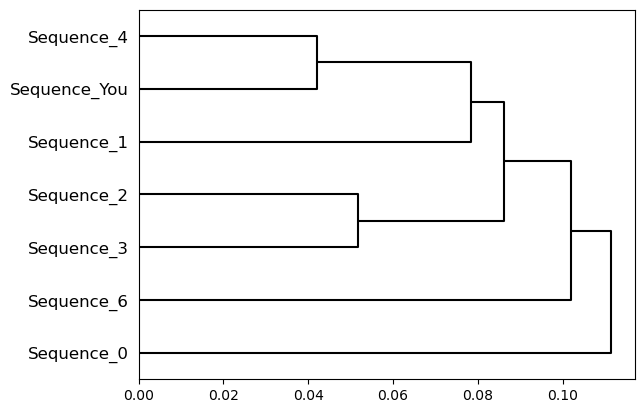

In [8]:
msa, tree = progressive_msa_and_tree(
    sequences=query_sequences,
    pairwise_aligner=global_pairwise_align_nucleotide,
    display_aln=True,
    display_tree=True,
)

In [9]:
msa_dm = skbio.DistanceMatrix.from_iterable(iterable=msa, metric=skbio.sequence.distance.hamming, key="id")

ordered = sorted(list(zip(msa_dm[msa_dm.ids.index("Sequence_You")], msa_dm.ids)))

def convert_index_to_lineage(index: int):
    if index == 0: return 'Sequence_You'
    elif index <= 2: return 'Sequence_Parent'
    elif index > 2 and index <= 6: return 'Sequence_Grandparent'
    else: return 'Index_Too_Big'

ordered_lineage = {t[1]: convert_index_to_lineage(index) for index, t in enumerate(ordered)}
print(ordered)
print(ordered_lineage)

[(0.0, 'Sequence_You'), (0.17455621301775148, 'Sequence_3'), (0.19822485207100593, 'Sequence_4'), (0.2465483234714004, 'Sequence_2'), (0.2859960552268245, 'Sequence_6'), (0.3037475345167653, 'Sequence_0'), (0.3037475345167653, 'Sequence_1')]
{'Sequence_You': 'Sequence_You', 'Sequence_3': 'Sequence_Parent', 'Sequence_4': 'Sequence_Parent', 'Sequence_2': 'Sequence_Grandparent', 'Sequence_6': 'Sequence_Grandparent', 'Sequence_0': 'Sequence_Grandparent', 'Sequence_1': 'Sequence_Grandparent'}


In [10]:
#print(ordered_lineage[seq.metadata['description']])
with open(output_file_path, 'w') as output_file:
    for seq in skbio.io.read(input_file_path, format='fasta'):
        seq.metadata['description'] = ordered_lineage[seq.metadata['description']]
        seq.write(output_file)

In [11]:
def iterative_msa_and_tree(
    sequences,
    num_iterations,
    pairwise_aligner,
    metric=kmer_distance,
    display_aln=False,
    display_tree=False,
):
    """Perform progressive msa of sequences and build a UPGMA tree
    Parameters
    ----------
    sequences : skbio.SequenceCollection
       The sequences to be aligned.
    num_iterations : int
       The number of iterations of progressive multiple sequence alignment to
       perform. Must be greater than zero and less than five.
    pairwise_aligner : function
       Function that should be used to perform the pairwise alignments,
       for example skbio.alignment.global_pairwise_align_nucleotide. Must
       support skbio.Sequence objects or skbio.TabularMSA objects
       as input.
    metric : function, optional
      Function that returns a single distance value when given a pair of
      skbio.Sequence objects. This will be used to build a guide tree if one
      is not provided.
    display_aln : bool, optional
       Print the alignment before returning.
    display_tree : bool, optional
       Print the tree before returning.

    Returns
    -------
    skbio.alignment
    skbio.TreeNode

    """
    if num_iterations > 5:
        raise ValueError(
            "A maximum of five iterations is allowed."
            "You requested %d." % num_iterations
        )
    previous_iter_tree = None
    for i in range(num_iterations):
        if i == (num_iterations - 1):
            # only display the last iteration
            display = True
        else:
            display = False
        previous_iter_msa, previous_iter_tree = progressive_msa_and_tree(
            sequences=sequences,
            pairwise_aligner=pairwise_aligner,
            metric=metric,
            guide_tree=previous_iter_tree,
            display_aln=display_aln and display,
            display_tree=display_tree and display,
        )

    return previous_iter_msa, previous_iter_tree

In [12]:
'''msa_1, tree_1 = iterative_msa_and_tree(
    sequences=query_sequences,
    pairwise_aligner=global_pairwise_align_nucleotide,
    num_iterations=1,
    display_aln=True,
    display_tree=True,
)'''

'msa_1, tree_1 = iterative_msa_and_tree(\n    sequences=query_sequences,\n    pairwise_aligner=global_pairwise_align_nucleotide,\n    num_iterations=1,\n    display_aln=True,\n    display_tree=True,\n)'

In [13]:
from copy import deepcopy
tree_copy = tree.deepcopy()

In [14]:
print(tree)
print(tree.find('Sequence_You'))

('Sequence_0':0.05571352496650559,('Sequence_6':0.05094794816651973,(('Sequence_3':0.02586206896551724,'Sequence_2':0.02586206896551724):0.01722391887314439,('Sequence_1':0.039207650273224044,('Sequence_You':0.02100840336134454,'Sequence_4':0.02100840336134454):0.018199246911879505):0.003878337565437588):0.007861960327858096):0.004765576799985863);

'Sequence_You':0.02100840336134454;



In [15]:
def find_distances_to_parents(tree, target_tip):
    target_node = tree.find(target_tip)
    distances = []
    current_node = target_node

    # Traverse upwards from the target node to the root, recording distances
    while current_node.parent is not None:
        distance_to_parent = current_node.length
        parent_name = current_node.parent.name if current_node.parent.name else "Root"
        distances.append((parent_name, distance_to_parent))
        current_node = current_node.parent

    return distances

# Calculate the distances from 'Sequence_You' to each of its parent nodes
distances_to_parents = find_distances_to_parents(tree, 'Sequence_You')
print(distances_to_parents)

[('Root', 0.02100840336134454), ('Root', 0.018199246911879505), ('Root', 0.003878337565437588), ('Root', 0.007861960327858096), ('Root', 0.004765576799985863)]


In [16]:
# 'Sequence_You' is a placeholder. Replace it with the actual node name in your tree.
sequence_you = tree.find('Sequence_You')



# Calculate distances from 'Sequence_You' to all other tip nodes.
distances = {}
for tip in tree.tips():
    if tip.name != 'Sequence_You':
        distance = sequence_you.distance(tip)
        distances[tip.name] = distance

print(distances)

{'Sequence_0': 0.11142704993301118, 'Sequence_6': 0.10189589633303946, 'Sequence_3': 0.08617197567732326, 'Sequence_2': 0.08617197567732326, 'Sequence_1': 0.07841530054644809, 'Sequence_4': 0.04201680672268908}


In [17]:
def find_hierarchy_levels(tree, target_tip):
    target_node = tree.find(target_tip)
    levels_of_hierarchy = {}

    for tip in tree.tips():
        if tip.name != target_tip:
            # Find the most recent common ancestor (MRCA) of target_node and the current tip
            mrca = tree.find(tip.name).lowest_common_ancestor(target_node)
            # Count the number of nodes from the MRCA to the target node and from MRCA to the current tip
            path_length_to_target = len(mrca.ancestors()) - len(target_node.ancestors())
            path_length_to_tip = len(mrca.ancestors()) - len(tip.ancestors())
            total_path_length = abs(path_length_to_target) + abs(path_length_to_tip)
            levels_of_hierarchy[tip.name] = total_path_length

    return levels_of_hierarchy

# Calculate the number of levels of hierarchy between 'Sequence_You' and all other tip nodes
hierarchy_levels = find_hierarchy_levels(tree_copy, 'Sequence_You')

print(heirarchy_levels)

ValueError: No tips found.

In [ ]:
def tree_to_dict(tree):
    """
    Convert an skbio tree to a dictionary representation.
    
    Parameters:
    - tree: skbio.TreeNode object representing the root of the tree.
    
    Returns:
    - A dictionary representation of the tree.
    """
    node_dict = {'name': tree.name}
    
    if tree.children:
        node_dict['children'] = [tree_to_dict(child) for child in tree.children]
    
    return node_dict

# Assuming `tree` is your skbio tree
# You can then convert it to a dictionary using the tree_to_dict function
tree_dict = tree_to_dict(tree)

# Now `tree_dict` contains the dictionary representation of your skbio tree
print(tree_dict)

In [ ]:
from skbio import TreeNode

def get_tip_distances(tree, target_tip_name):
    """
    Calculate the distance from a target tip node to all other tip nodes in the tree.
    
    Parameters:
    - tree: skbio.TreeNode object representing the root of the tree.
    - target_tip_name: Name of the target tip node from which distances are calculated.
    
    Returns:
    - A dictionary where keys are tip node names and values are the distances from the target tip node.
    """
    distances = {}
    
    # Find the target tip node
    target_tip_node = tree.find(target_tip_name)
    if target_tip_node is None:
        raise ValueError(f"Tip node '{target_tip_name}' not found in the tree.")
    
    # Iterate over all tip nodes in the tree
    for tip_node in tree.tips():
        if tip_node != target_tip_node:
            # Calculate the distance from the target tip node to each tip node
            distance = tree.distance(target_tip_node)
            distances[tip_node.name] = distance
    
    return distances

# Example usage:
# Assuming `tree` is your skbio tree
# and `Sequence_You` is the name of the target tip node
distances = get_tip_distances(tree, 'Sequence_You')
print(distances)



In [ ]:
# 'Sequence_You' is a placeholder. Replace it with the actual node name in your tree.
sequence_you = tree.find('Sequence_You')

# Calculate distances from 'Sequence_You' to all other tip nodes.
distances = {}
for tip in tree.tips():
    if tip.name != 'Sequence_You':
        distance = sequence_you.distance(tip)
        distances[tip.name] = distance

# Print the distances
for tip, distance in distances.items():
    print(f"Distance from Sequence_You to {tip}: {distance}")

# To determine the number of levels of hierarchy, you would interpret these distances.
# The exact interpretation depends on the tree's scale and the biological context.
